In [169]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torchvision.transforms import transforms
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.pyplot import imshow
%matplotlib inline
import cv2

In [170]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

In [171]:
print(device)

cpu


In [172]:
# Loding the data file as read only file and assigning it as numpy array. 
filename = 'combustion_img_13.mat'
with h5py.File(filename, 'r') as f:
    x_train = np.array(f['train_set_x'])
    y_train = np.array(f['train_set_y'])
    x_val = np.array(f['valid_set_x'])
    y_val = np.array(f['valid_set_y'])
    x_test = np.array(f['test_set_x'])
    y_test = np.array(f['test_set_y'])

In [173]:
save_path = 'C:\\Users\\mbshoa\\OneDrive - Emerson\\Desktop\\ME 592\\combustion'

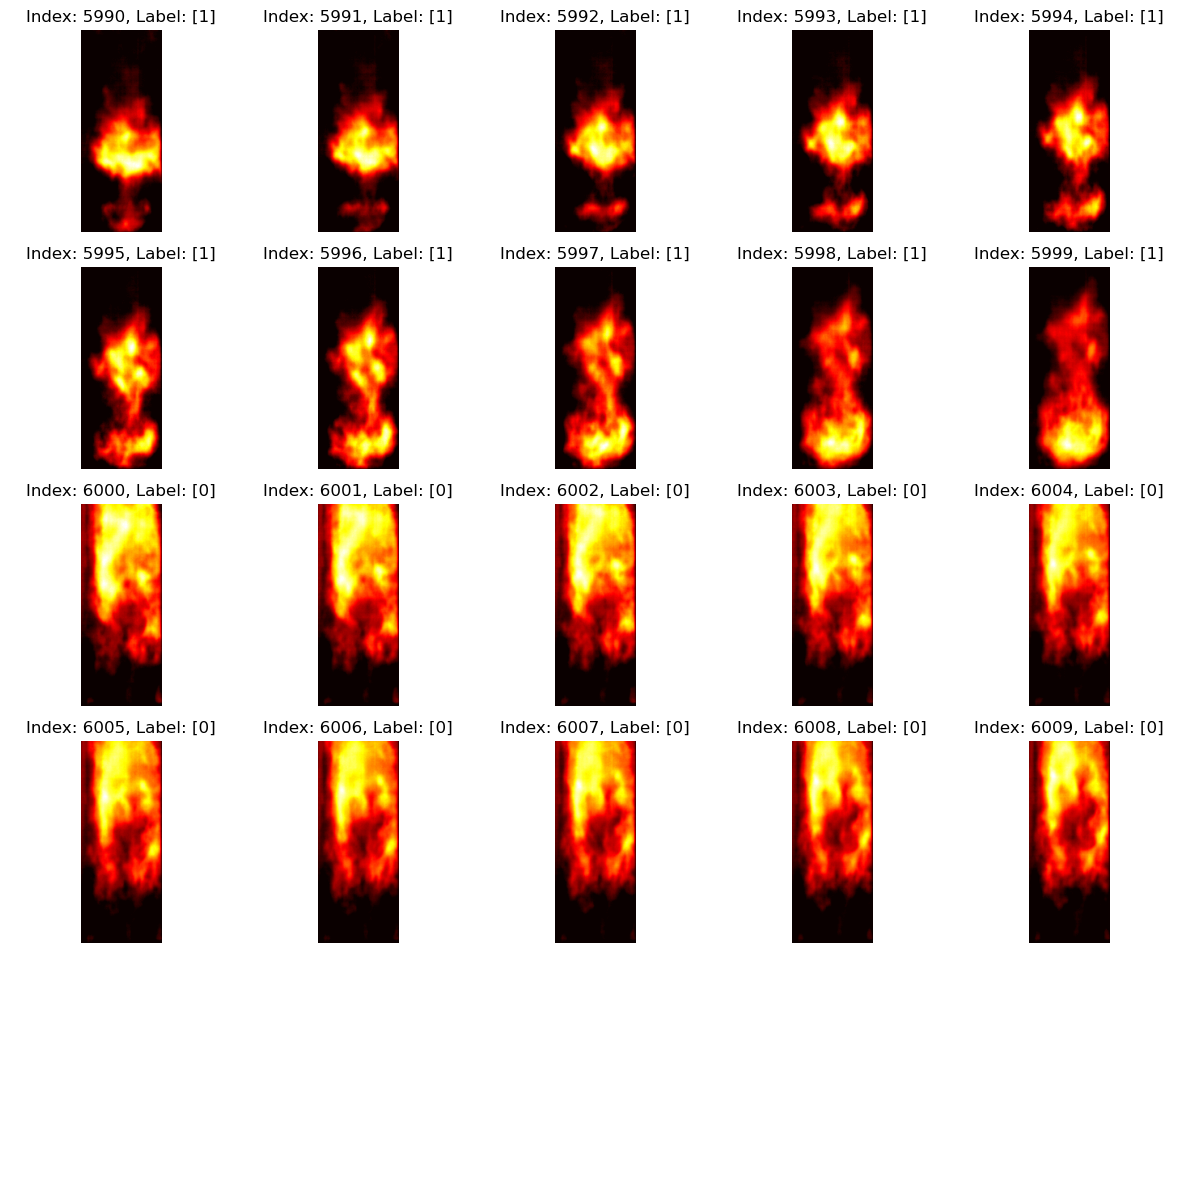

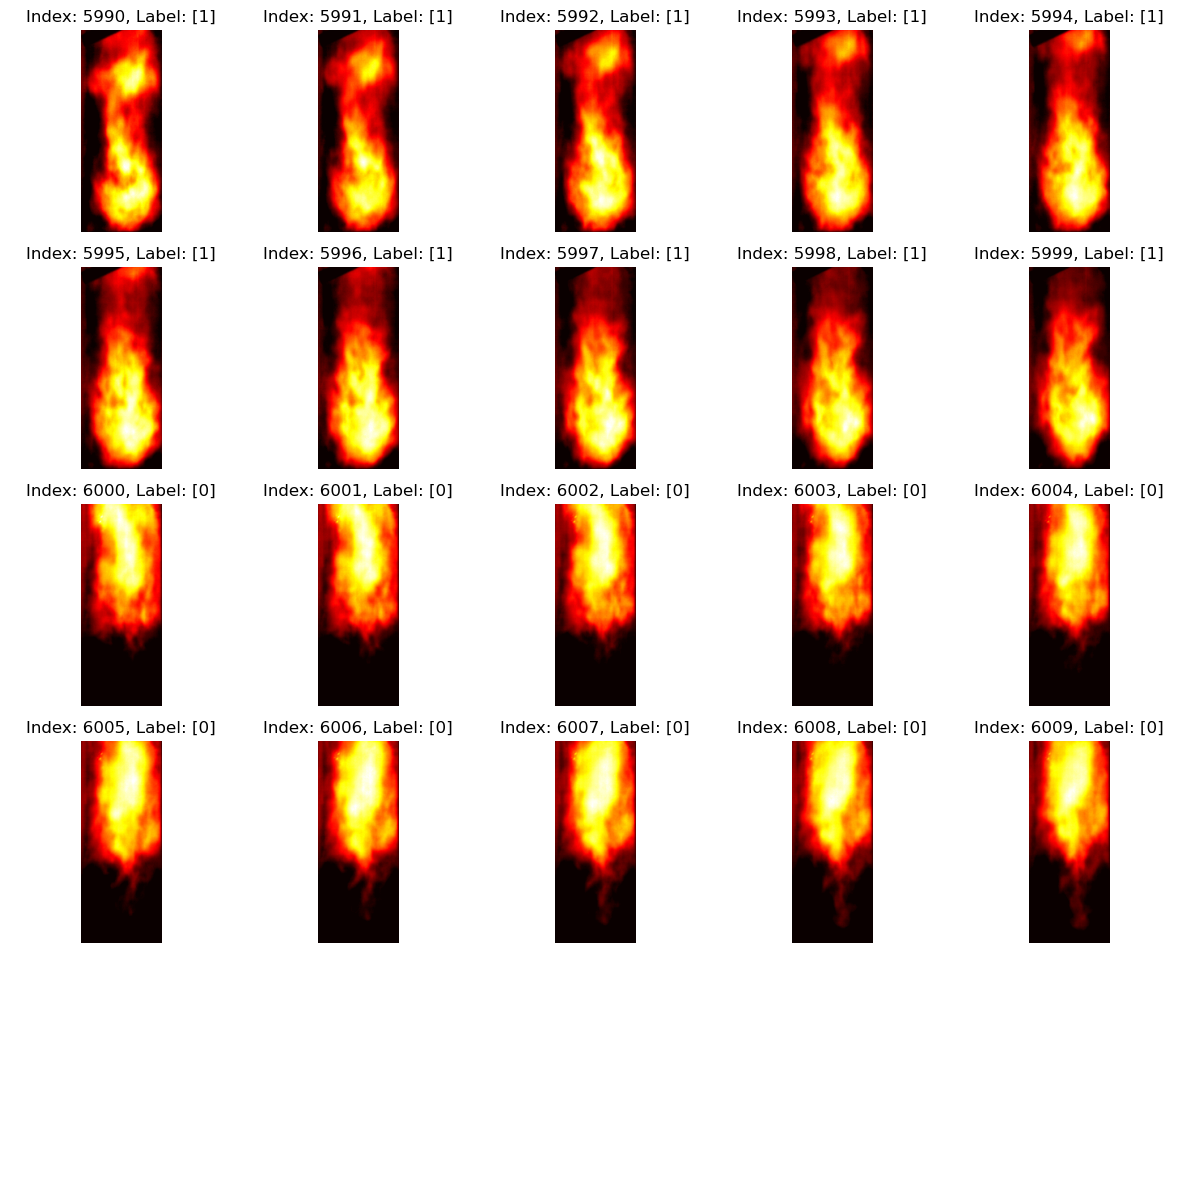

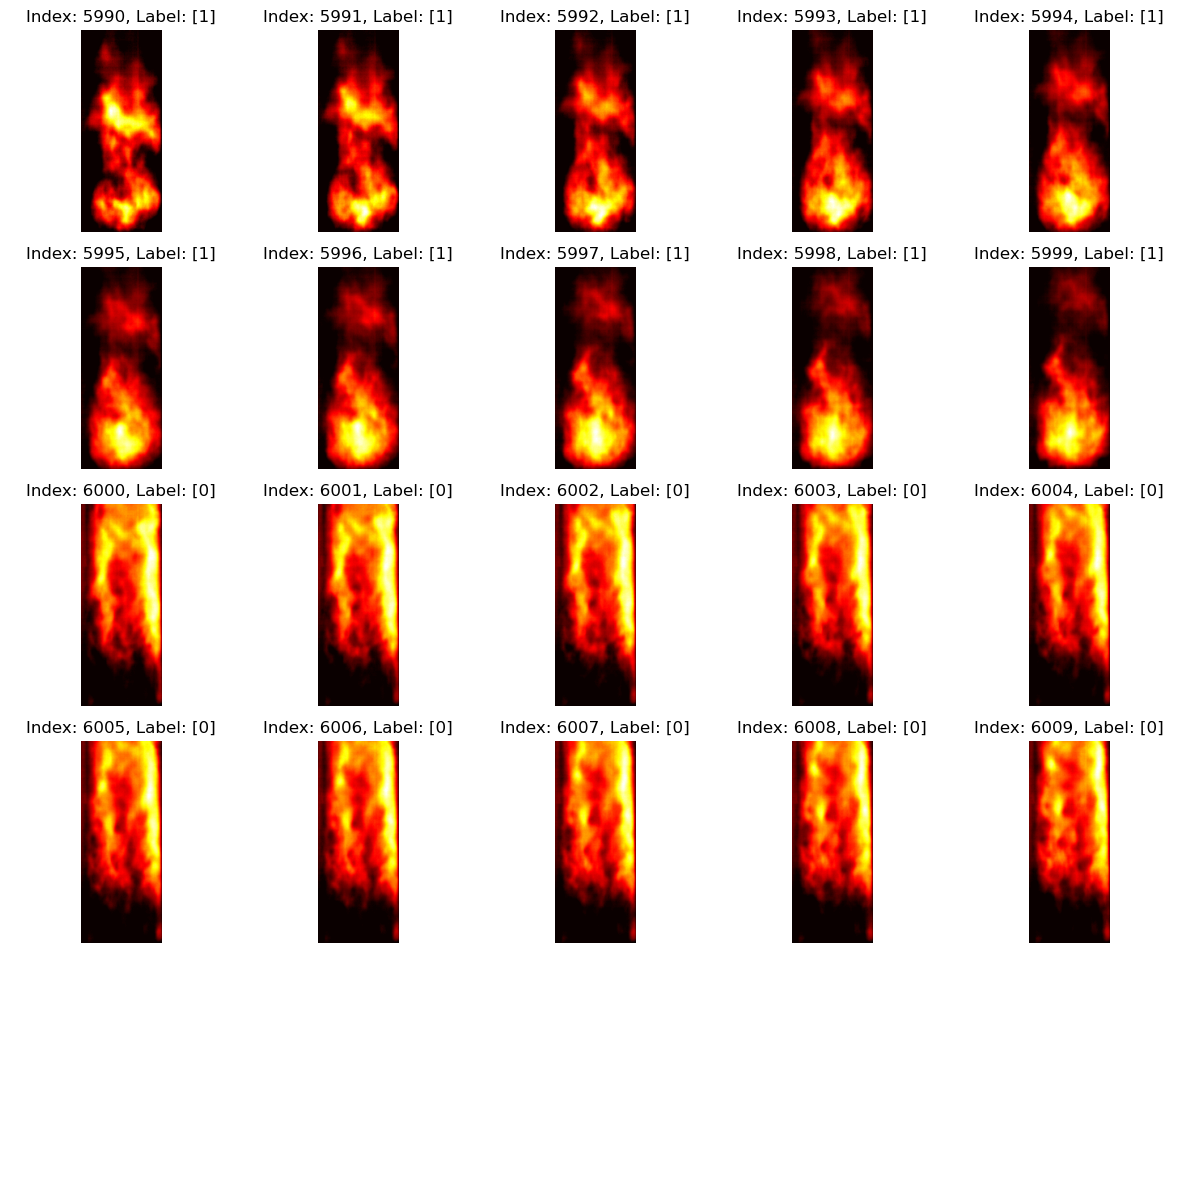

In [176]:
def save_images(data, labels, folder_name, start_index, end_index, plot_grid=True):
    folder_path = os.path.join(save_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    # Transpose labels if needed
    if labels.shape[0] == 1:
        labels = labels.T

    num_images = end_index - start_index
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    idx = 0
    for i in range(start_index, end_index):
        img = data[:, i].reshape(250, 100)
        label = labels[i]

        img_path = os.path.join(folder_path, f"img_{i}_label_{label}.png")
        cv2.imwrite(img_path, img)

        if plot_grid:
            row, col = idx // grid_size, idx % grid_size
            axs[row, col].imshow(img, cmap='hot')
            axs[row, col].set_title(f"Index: {i}, Label: {label}")
            axs[row, col].axis('off')
            idx += 1

    if plot_grid:
        for i in range(idx, grid_size * grid_size):
            row, col = i // grid_size, i % grid_size
            axs[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
index_start = 5990
index_end = 6010
save_images(x_train, y_train, 'train', start_index=index_start, end_index=index_end)
save_images(x_test, y_test, 'test', start_index=index_start, end_index=index_end)
save_images(x_val, y_val, 'val', start_index=index_start, end_index=index_end)

In [165]:
# Normalizing the pixel values to the range [0, 1]; also converting data to float32 type for division operation
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_val = x_val.astype(np.float32) / 255.0

In [166]:
# Reshaping images from 1D to 4D array (#images, height, width, #channels) and transposing the data into (batch_size, channels, height , width)
x_train = np.transpose(x_train.reshape(-1, 250, 100, 1), (0, 3, 1, 2))
x_test = np.transpose(x_test.reshape(-1, 250, 100, 1), (0, 3, 1, 2))
x_val = np.transpose(x_val.reshape(-1, 250, 100, 1), (0, 3, 1, 2))

In [167]:
# Encoding the labels 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [143]:
# Converting data to PyTorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

In [144]:
# Creating PyTorch datasets
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
val_dataset = TensorDataset(x_val, y_val)

In [145]:
#Hyper parameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001

In [146]:
# Creating PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [147]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
   
    #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (N, 1, 250, 100)
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (N, 1, 250, 100)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (N, 12, 250, 100)
        self.relu1=nn.ReLU()
        #Shape= (N, 12, 250, 100)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (N, 12, 125, 50)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (N, 12, 125, 50)
        self.relu2=nn.ReLU()
        #Shape= (N, 20, 125, 50)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (N, 32, 125, 50)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (N, 32, 125, 50)
        self.relu3=nn.ReLU()
        #Shape= (N, 32, 125, 50)
        
        
        self.fc=nn.Linear(in_features=125 * 50 * 32,out_features=num_classes)
        
        
        
        #forward pass
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (54000, 32, 125, 50)
            
        output=output.view(-1,32*125*50)
                        
        output=self.fc(output)
            
        return output

In [148]:
model = ConvNet()
optimizer=Adam(model.parameters(),lr=learning_rate,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [149]:
train_count = len(train_dataset)
test_count = len(test_dataset)

In [150]:
print('Hyperparameters')
print('batch_size = ',batch_size)
print('num_epochs = ', num_epochs)
print('learning_rate = ', learning_rate)
# set the model to training mode
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0
    train_accuracy = 0
    
    # training loop
    for images, labels in train_loader:
        # move data to GPU if available
        images, labels = images.to(device), labels.to(device)
        
        # set the model to training mode
        model.train()
        
        # forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)
        
        # backward pass and weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update training loss and accuracy
        train_loss += loss.item() * images.size(0)
        train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels)
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = train_accuracy / train_count
    
    # set the model to evaluation mode
    model.eval()
    test_accuracy = 0
    
    # testing loop
    with torch.no_grad():
        for images, labels in test_loader:
            # move data to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            # set the model to evaluation mode
            model.eval()
            
            # forward pass
            outputs = model(images)
            
            # update test accuracy
            test_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels)
    
    test_accuracy = test_accuracy / test_count
    
    # print the epoch, training loss, training accuracy, and test accuracy
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.4f} Test Acc: {test_accuracy:.4f}")


Epoch 1 - Train Loss: 1.1006 Train Acc: 0.8310 Test Acc: 0.5618
Epoch 2 - Train Loss: 0.1921 Train Acc: 0.9381 Test Acc: 0.5391
Epoch 3 - Train Loss: 0.1146 Train Acc: 0.9580 Test Acc: 0.5190
Epoch 4 - Train Loss: 0.1031 Train Acc: 0.9624 Test Acc: 0.5187
Epoch 5 - Train Loss: 0.1009 Train Acc: 0.9630 Test Acc: 0.5356
Epoch 6 - Train Loss: 0.0936 Train Acc: 0.9668 Test Acc: 0.5263
Epoch 7 - Train Loss: 0.0896 Train Acc: 0.9669 Test Acc: 0.5433
Epoch 8 - Train Loss: 0.0854 Train Acc: 0.9699 Test Acc: 0.5333
Epoch 9 - Train Loss: 0.0857 Train Acc: 0.9700 Test Acc: 0.5551
Epoch 10 - Train Loss: 0.0791 Train Acc: 0.9725 Test Acc: 0.5282
